In [63]:
from __future__ import print_function
from pythtb import *
import numpy as np
import matplotlib.pyplot as plt

## Haldane Model

In [64]:
def Haldane(delta, t, t2):
    lat=[[1, 0],[0.5, np.sqrt(3)/2]]
    orb=[[1/3, 1/3],[2/3, 2/3]]

    model = tb_model(2, 2, lat, orb)

    model.set_onsite([-delta, delta], mode='reset')

    for lvec in ([0, 0], [-1, 0], [0, -1]):
        model.set_hop(t, 0, 1, lvec, mode='reset')
        model.set_hop(t, 0, 1, lvec, mode='reset')

    for lvec in ([1, 0], [-1, 1], [0, -1]):
        model.set_hop(t2*1j, 0, 0, lvec, mode='reset')
        model.set_hop(t2*-1j, 1, 1, lvec, mode='reset')

    return model

In [65]:
delta = 0.2
t = -1
t2 = 0.15

my_model = Haldane(delta, t, t2)

In [66]:
path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0]]
label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $')

nk = 51
(k_vec, k_dist, k_node) = my_model.k_path(path, nk, report=False)

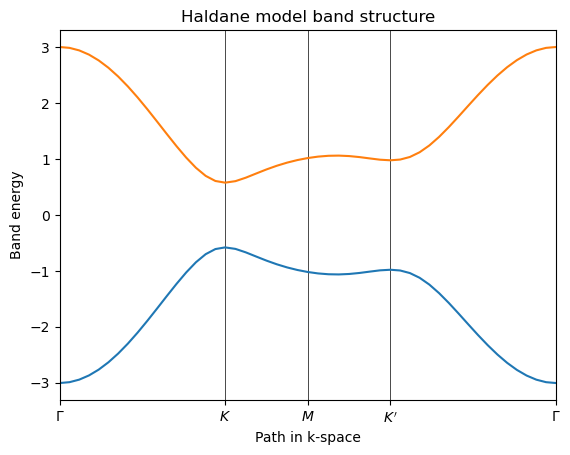

In [67]:
evals = my_model.solve_all(k_vec)

# figure for bandstructure
fig, ax = plt.subplots()
ax.set_xlim(k_node[0], k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(label)

ax.set_title("Haldane model band structure")
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Band energy")

# add vertical lines at node positions
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

# plot bands
for n in range(len(evals)):
  ax.plot(k_dist, evals[n])

plt.savefig('single_cell.png')

## Doubling the unit cell (band folding)

In [68]:
# double unit cell in both directions (reduced units)
model = Haldane(delta, t, t2).make_supercell([[2,0],[0,2]])

#adding disorder
J = 0.2
J_site = 2
model.set_onsite(J, ind_i = J_site, mode='add')

In [69]:
(k_vec_dbld, k_dist_dbld, k_node_dbld) = model.k_path(path, nk, report=False)

In [70]:
evals_dbld = model.solve_all(k_vec)

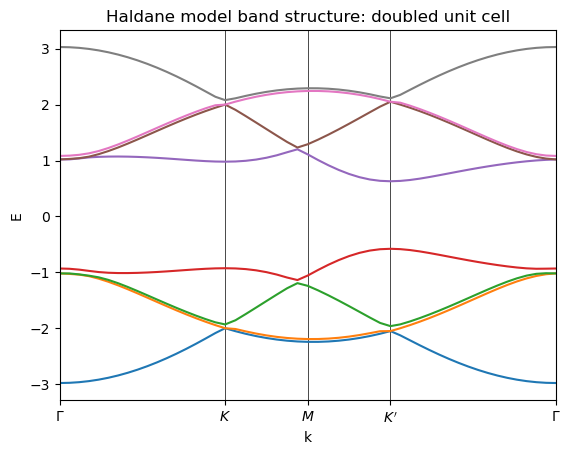

In [71]:
# figure for bandstructure
fig, ax = plt.subplots()
ax.set_xlim(k_node_dbld[0], k_node_dbld[-1])
ax.set_xticks(k_node_dbld)
ax.set_xticklabels(label)

ax.set_title("Haldane model band structure: doubled unit cell")
ax.set_xlabel("k")
ax.set_ylabel("E")

# add vertical lines at node positions
for n in range(len(k_node_dbld)):
  ax.axvline(x=k_node_dbld[n], linewidth=0.5, color='k')

for n in range(len(evals_dbld)):
  ax.plot(k_dist_dbld, evals_dbld[n])

  plt.savefig('doubled_cell.png')

## Finding singularities in $det(S_k)^{-1/2}$

In [72]:
num_param = 8

# paramater space
t_arr = np.linspace(0, 1, num_param)
t2_arr = np.linspace(0, .2, num_param)

# containers for quantities of interest
det_Sk = np.zeros((num_param, num_param, nk))
chern_arr = np.zeros((num_param, num_param))

In [73]:
for i in range(num_param):
    for j in range(num_param):
        # set parameters
        t, t2 = t_arr[i], t2_arr[j]

        # make model
        model = Haldane(delta, t, t2)

        # wf array for whole BZ
        my_array_whole = wf_array(model, [nk, nk])
        my_array_whole.solve_on_grid([0,0])

        # compute chern number
        chern = my_array_whole.berry_flux([0])/ (2*np.pi)
        chern_arr[i, j] = chern
        print(f'indices: {i, j}, C = {chern: .2f} | Delta = {delta: .2f}, t = {t: .2f} t2 = {t2: .2f}')

        # find det(S_k) on path in k-space
        my_array_path = wf_array(model, [nk])
        for k in range(k_vec.shape[0]):
            my_array_path.solve_on_one_point([k_vec[k,0], k_vec[k,1]], [k])
            # overlap of lower energy state with delta function on site at origin of unit cell
            det_Sk[i, j, k] = np.abs(my_array_path[k][0][0]) 

/Users/treycole/mambaforge/envs/rutgers/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/treycole/mambaforge/envs/rutgers/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


indices: (0, 0), C =  0.00 | Delta =  0.20, t =  0.00 t2 =  0.00
indices: (0, 1), C =  0.00 | Delta =  0.20, t =  0.00 t2 =  0.03
indices: (0, 2), C =  0.00 | Delta =  0.20, t =  0.00 t2 =  0.06
indices: (0, 3), C =  0.00 | Delta =  0.20, t =  0.00 t2 =  0.09
indices: (0, 4), C =  0.00 | Delta =  0.20, t =  0.00 t2 =  0.11
indices: (0, 5), C =  0.00 | Delta =  0.20, t =  0.00 t2 =  0.14
indices: (0, 6), C =  0.00 | Delta =  0.20, t =  0.00 t2 =  0.17
indices: (0, 7), C =  0.00 | Delta =  0.20, t =  0.00 t2 =  0.20
indices: (1, 0), C =  0.00 | Delta =  0.20, t =  0.14 t2 =  0.00
indices: (1, 1), C =  0.00 | Delta =  0.20, t =  0.14 t2 =  0.03
indices: (1, 2), C = -1.00 | Delta =  0.20, t =  0.14 t2 =  0.06
indices: (1, 3), C = -1.00 | Delta =  0.20, t =  0.14 t2 =  0.09
indices: (1, 4), C = -1.00 | Delta =  0.20, t =  0.14 t2 =  0.11
indices: (1, 5), C = -1.00 | Delta =  0.20, t =  0.14 t2 =  0.14
indices: (1, 6), C = -1.00 | Delta =  0.20, t =  0.14 t2 =  0.17
indices: (1, 7), C = -1.0

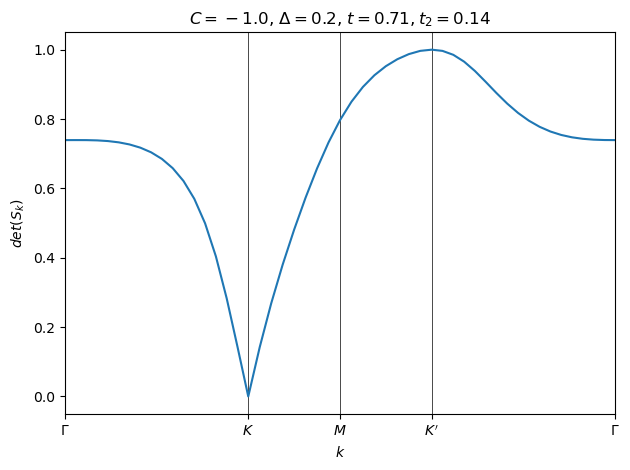

In [74]:
# parameter indicies
idx1, idx2 = 5, 5

fig, ax = plt.subplots()
ax.set_xlim(0,k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(label)
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

ax.plot(k_dist, det_Sk[idx1, idx2, :])

ax.set_title(fr"$C = {chern_arr[idx1, idx2]: .1f}$, $\Delta = {delta}$, $t= {t_arr[idx1]: .2f}, t_2 = {t2_arr[idx2]: .2f}$")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$det(S_k)$")
fig.tight_layout()

##  Doubled unit cell 

- Add disorder on 1 site to break symmetry and remove degeneracies
- Use SVD of $A_k$ to see where the singular values go to zero. At these points, there is a divergence in Wannier construction

In [75]:
# some nontrivial paramters
# delta = 1
t = t_arr[idx1]
t2 = t2_arr[idx2]

model = Haldane(delta, t, t2).make_supercell([[2,0],[0,2]])

# adding disorder
J = 2
J_site = 2
model.set_onsite(J, ind_i = J_site, mode='add')
# model.set_onsite(3, ind_i = 3, mode='add')


# wave function storage
wfs = wf_array(model, [nk])

-  lower energy sites are 0, 2, 4, 6
-  trial function is delta function at each of these sites
- $A(k)$ is a matrix that is the overlap of each eigenstate with a given trial function

In [76]:
trial_orbitals = [0, 4, 6] 
num_occ_bands = 4

A = np.zeros((nk, num_occ_bands, len(trial_orbitals)), dtype=complex)
V = np.zeros((nk, num_occ_bands, num_occ_bands), dtype=complex)
S = np.zeros((nk, len(trial_orbitals)), dtype=complex)
W = np.zeros((nk, len(trial_orbitals), len(trial_orbitals)), dtype=complex)

for k in range(nk):
    wfs.solve_on_one_point([k_vec[k, 0], k_vec[k, 1]], [k])
    # constructing A
    A[k, :, :] = [[wfs[k][i][j].conj() for j in trial_orbitals] for i in range(num_occ_bands)]
    # SVD
    V[k, :, :], S[k, :], W[k, :, :] = np.linalg.svd(A[k])

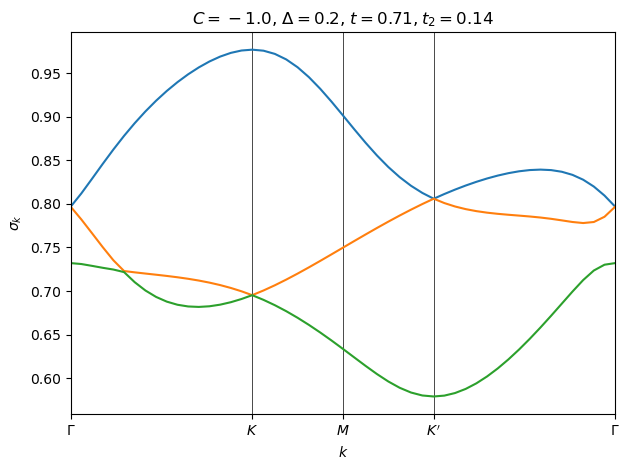

In [77]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(label)
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

for n in range(S.shape[1]):
  ax.plot(k_dist, S[:, n])

ax.set_title(fr"$C = {chern_arr[idx1, idx2]: .1f}$, $\Delta = {delta}$, $t= {t_arr[idx1]: .2f}, t_2 = {t2_arr[idx2]: .2f}$")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\sigma_k$")
fig.tight_layout()

### $\sqrt{3} \times \sqrt{3}$ unit cell

In [78]:
# some nontrivial paramters
# delta = 1
t = t_arr[idx1]
t2 = t2_arr[idx2]

model = Haldane(delta, t, t2).make_supercell([[2, -1],[1, 1]])

# adding disorder
J = 2
J_site = 2
model.set_onsite(J, ind_i = J_site, mode='add')

# wave function storage
wfs = wf_array(model, [nk])

In [81]:
model.display()

---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 2
r-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 6
number of electronic states = 6
lattice vectors:
 #  0  ===>  [     1.5 ,  -0.866 ]
 #  1  ===>  [     1.5 ,   0.866 ]
positions of orbitals:
 #  0  ===>  [     0.0 ,  0.3333 ]
 #  1  ===>  [     0.0 ,  0.6667 ]
 #  2  ===>  [  0.3333 ,  0.6667 ]
 #  3  ===>  [  0.3333 ,     1.0 ]
 #  4  ===>  [  0.6667 ,     1.0 ]
 #  5  ===>  [  0.6667 ,  0.3333 ]
site energies:
 #  0  ===>      -0.2
 #  1  ===>       0.2
 #  2  ===>       1.8
 #  3  ===>       0.2
 #  4  ===>      -0.2
 #  5  ===>       0.2
hoppings:
<  0 | H |  1 + [  0 ,  0 ] >     ===>   0.7143 +     0.0 i
<  0 | H |  5 + [ -1 ,  0 ] >     ===>   0.7143 +     0.0 i
<  0 | H |  3 + [  0 , -1 ] >     ===>   0.7143 +     0.0 i
<  0 | H |  2 + [  0 ,  0 ] >     ==

In [84]:
trial_orbitals = [0, 4] 
num_occ_bands = 3

A = np.zeros((nk, num_occ_bands, len(trial_orbitals)), dtype=complex)
V = np.zeros((nk, num_occ_bands, num_occ_bands), dtype=complex)
S = np.zeros((nk, len(trial_orbitals)), dtype=complex)
W = np.zeros((nk, len(trial_orbitals), len(trial_orbitals)), dtype=complex)

for k in range(nk):
    wfs.solve_on_one_point([k_vec[k, 0], k_vec[k, 1]], [k])
    A[k, :, :] = [[wfs[k][i][j].conj() for j in trial_orbitals] for i in range(num_occ_bands)]
    # SVD
    V[k, :, :], S[k, :], W[k, :, :] = np.linalg.svd(A[k])

/Users/treycole/mambaforge/envs/rutgers/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


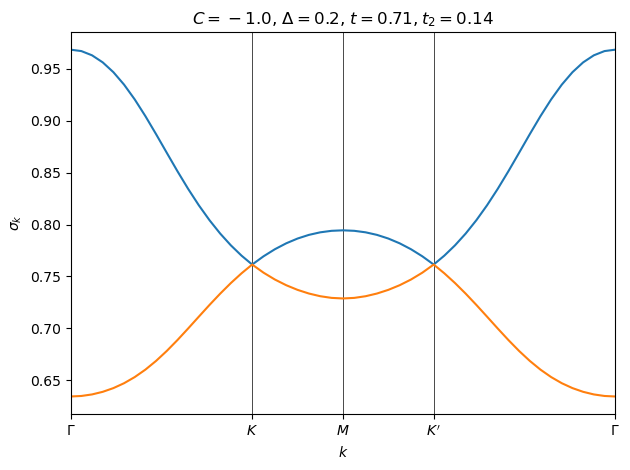

In [85]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(label)
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

for n in range(S.shape[1]):
  ax.plot(k_dist, S[:, n])

ax.set_title(fr"$C = {chern_arr[idx1, idx2]: .1f}$, $\Delta = {delta}$, $t= {t_arr[idx1]: .2f}, t_2 = {t2_arr[idx2]: .2f}$")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\sigma_k$")
fig.tight_layout()